## Выявление закономерностей определяющих успешность продаж компьютерных игр в интернет-магазине

В наличии исторические данные интернет-магазина до 2016 года о продажах по всему миру компьютерных игр из открытых источников, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании **необходимо выявить определяющие успешность игры закономерности**.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

### Шаг 1. Файл с данными и изучение общей информации

In [1]:
import pandas as pd #загрузка библиотек
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
import warnings

warnings.simplefilter('ignore')

In [3]:
games = pd.read_csv('/datasets/games.csv') #путь к файлу

In [4]:
games.head(7) #отображение первых 5 строк df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E


### Шаг 2. Подготовка данных

Замена названия столбцов (приведение к нижнему регистру).
<br>Обработка пропусков: заполнение их определённым образом или почему правки не требуются, причины возникновения пропусков.
<br>'tbd' в столбцах с рейтингом и описание их обработки.
<br>Преобразование данных в нужные типы (замены по столбцам и их причины).

In [5]:
games.info() #проверка типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


##### Замена названий столбцов (по регистру)

In [6]:
games.columns = games.columns.str.lower() #замена названий всех столбцов df на нижний регистр

In [7]:
games['genre'] = games['genre'].str.lower() #замена названий в столбце на нижний регистр
games['platform'] = games['platform'].str.lower()

##### Замена пропусков в столбцах и преобразование данных в нужный тип

In [8]:
games.isna().sum() #проверка выборки на предмет пропусков

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

<br>Целесообразно не осуществлять импутацию данных по следующим столбцам 'critic_score', 'user_score', 'rating' (порядка 40-50% пропусков в каждом столбце)- т.е. не создавать дополнительный "шум". Рейтинг и оценки в таком объеме данных не могли "просто пропустить".
<br>Эти данные будут участвовать далее в анализе: корреляция с продажами, подтверждение гипотез. 
<br>Причинами появления могли стать нежелание обозначать оценки как пользователями, так и критикам; кроме того данные объединены из разных источников- возможно дело в разном фильтре на вход в опросах респондентов.

In [9]:
games['rating'].value_counts() #пропуски по 'rating'

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [10]:
games['critic_score'].value_counts() #пропуски по critic_score

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

In [11]:
games['user_score'].value_counts() #пропуски по user_score

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.3       2
1.1       2
0.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Замена по столбцу 'user_score': около 15% выборки или 2424 значений- "tbd" (to be done) и еще присутствуют 6701 NaN. Данная аббревиатура используется, "если какая-то информация еще не определена или решение по вопросу не принято"(вероятно по ним данные будут дополнены позже)- считаем данные значения за пропуски. NaN(6701) оставляем без изменения, аналогично по "tbd"(2424) с предварительной заменой на 'NaN'.

In [12]:
games['user_score'] = games['user_score'].replace('tbd', 'NaN') #замена tbd на NaN

Во избежание потери важных данных заменяем в столбцах 'critic_score', 'user_score', 'rating' NaN на "-".

In [13]:
games[['critic_score', 'user_score', 'rating']].fillna(value='-') #заполнение пропущенных значений заменой на "-"

,critic_score,user_score,rating
0,76,8,E
1,-,-,-
2,82,8.3,E
3,80,8,E
4,-,-,-
...,...,...,...
16710,-,-,-
16711,-,-,-
16712,-,-,-
16713,-,-,-


Удаление методом .dropna() строк с отсутствующими значениями по столбцам 'name', 'genre', 'year_of_release'- менее 2% данных выборки ( изъят "шум").

In [14]:
games = games.dropna(subset = ['name', 'genre', 'year_of_release'])

Тип данных по столбцам 'user_score' заменим на 'float', 'year_of_release' на 'int'.

In [15]:
games['user_score'] = games['user_score'].astype('float') #замена на 'float'

In [16]:
games['year_of_release'] = games['year_of_release'].astype('int') #замена на 'int'

In [17]:
# код ревьюера
#import sys
#sys.getsizeof(games['year_of_release']), sys.getsizeof(games['year_of_release'].astype('int'))

In [18]:
games.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [19]:
games.sample(10) #случайная выборка строк

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13739,Guilty Gear XX Accent Core,wii,2007,fighting,0.03,0.00,0.00,0.00,75.0,8.4,T
5277,Dark Void,ps3,2010,action,0.18,0.12,0.00,0.05,59.0,6.0,T
3436,Top Spin 3,wii,2008,action,0.15,0.37,0.00,0.07,68.0,5.7,E
7443,Rollcage,ps,1999,racing,0.12,0.08,0.00,0.01,NaN,NaN,NaN
11460,Outlaw Golf,gc,2002,sports,0.06,0.02,0.00,0.00,69.0,NaN,T
3401,WWE 2K16,xone,2015,sports,0.32,0.22,0.00,0.05,72.0,5.7,T
2411,SingStar '90s,ps2,2007,misc,0.10,0.59,0.00,0.18,73.0,NaN,T
2131,Donkey Kong Junior,2600,1981,platform,0.90,0.05,0.00,0.01,NaN,NaN,NaN
5172,"999: Nine Hours, Nine Persons, Nine Doors",ds,2009,adventure,0.31,0.00,0.03,0.02,NaN,NaN,NaN
6023,Madden NFL 08,xb,2007,sports,0.22,0.06,0.00,0.01,76.0,6.0,E


#### Расчет суммарных продаж во всем регионам и запись их в отдельный столбец

In [20]:
#добавление столбца с суммарными продажами
games['sales_sum'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [21]:
games.head(7)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80


#### Вывод:
Выборка обработана на предмет пропусков (в частности 'tbd') и типов данных, единого регистра столбцов; добавлен столбец 'sales_sum' с суммарными продажами.

### Шаг 3. Проведение исследовательского анализа данных

Количество игр выпускаемое в разные годы.
<br>Изменение продаж по платформам. Платформы с наибольшими суммарными продажами и распределение по годам. Характерный срок появления новых и исчезновение старых платформ.
По актуальному периоду: платформы лидеры по продажам, растут или падают? Несколько потенциально прибыльных платформ.
<br>График «ящик с усами» по глобальным продажам игр в разбивке по платформам.
<br>Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков. Диаграмма рассеяния и корреляция между отзывами и продажами. Соотнесение выводов с продажами игр на других платформах.
<br>Общее распределение игр по жанрам. Самые прибыльные жанры. Жанры с высокими и низкими продажами.

##### Количество игр по годам

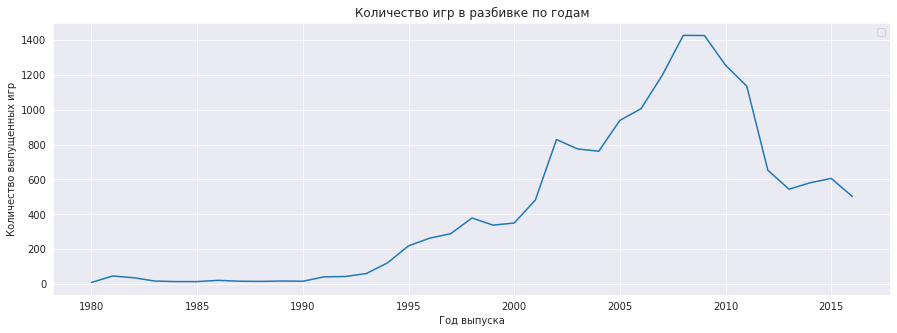

In [22]:
#сводная таблица игры по годам и гистограмма
games_in_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
sns.lineplot(data=games_in_year)
plt.title('Количество игр в разбивке по годам')
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')

Гистограмма отображает максимум по количеству игр на 2008 году и обвал после (точка экономического кризиса, инвесторы не спешили вкладывать деньги в проекты с отсрочками в получении прибыли и компании массово сокращались или закрывались). 
<br>Уровень данных в период 1980-1990г.г. стабилен и находится ближе к нулевым показателям, поэтому оптимально для дальнейшего анализа не брать его в расчет и ограничить анализируемый период рамками 2012-2016 гг.

##### Общие продажи по платформам

Text(0, 0.5, 'Суммарные продажи')

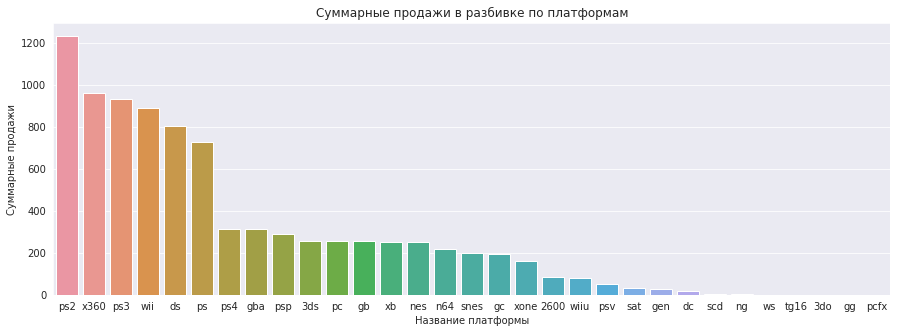

In [23]:
#сводная таблица продажи по платформам и гистограмма
sales_on_platform = games.pivot_table(index='platform', values='sales_sum', aggfunc='sum').sort_values(by='sales_sum', ascending=False) 

plt.figure(figsize=(15,5))
sns.barplot(x=sales_on_platform.index,y=sales_on_platform['sales_sum'])
plt.title('Суммарные продажи в разбивке по платформам')
plt.xlabel("Название платформы")
plt.ylabel("Суммарные продажи")

Далее суммарные продажи по платформам top-5 с актуальным период 2012-2016 гг., чтобы учесть тенденции быстро меняющейся индустрии, представлены отдельно на гистограмме (c выручкой в диапазоне 314.14-159.32 млн. проданных копий)- из них наиболее значимые: *PS4, PS3, X360*.

In [24]:
games_up_2011 = games.query('year_of_release > 2011') #cрез методом .query с актуальным периодом 2012-2016гг.

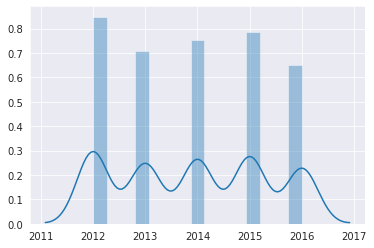

In [25]:
sns.distplot(games_up_2011[['year_of_release']])

In [26]:
#сводная таблица продажи-платформы top-5
sales_on_platform_top5 = games_up_2011.pivot_table(index = 'platform', values = 'sales_sum', aggfunc = 'sum').sort_values(by='sales_sum', ascending=False).head(5)
sales_on_platform_top5 = sales_on_platform_top5.reset_index().rename_axis(None, axis=1)
sales_on_platform_top5

,platform,sales_sum
0,ps4,314.14
1,ps3,288.79
2,x360,236.54
3,3ds,194.61
4,xone,159.32


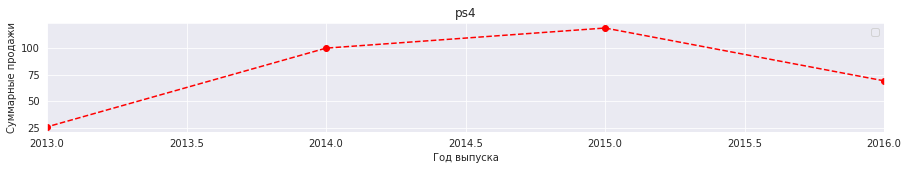

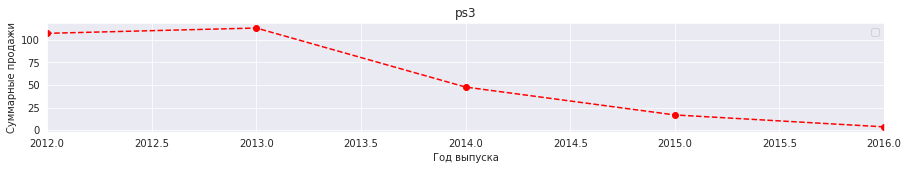

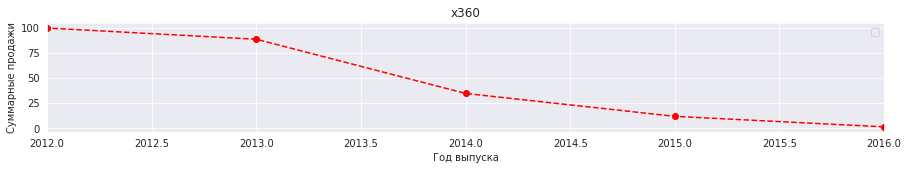

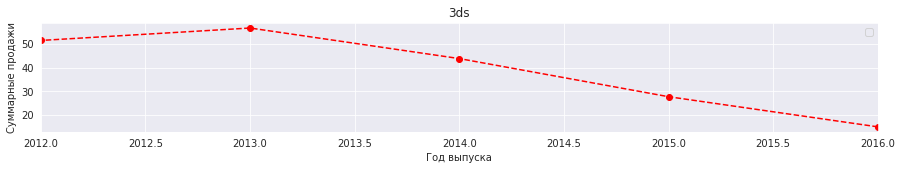

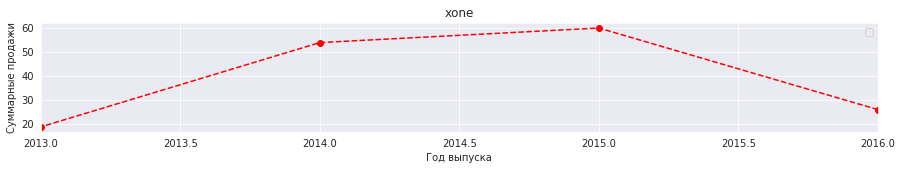

In [27]:
#гистограмма продажи-платформы top-5 через цикл
top_5 = games_up_2011.groupby(['platform'], 
            as_index = False)['sales_sum'].sum().sort_values('sales_sum', 
                                ascending = False).head(5)['platform']

for name in top_5:
    games_up_2011.query('platform == @name').pivot_table(index = 'year_of_release',
                        values = 'sales_sum', aggfunc = 'sum').sort_values('year_of_release', 
                                                    ascending = False).plot(figsize = (15, 2), title = name, colormap='prism', linestyle = '--', marker = 'o')
    
    #plt.title('Суммарные продажи в разбивке по платформам (top-5)')
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи')
    plt.legend('')

Распределение по годам платформ отражает ее время "появления-исчезновения" на рынке продажи интернет-игр: в среднем этот период равен 10 лет.
<br>Актуальным периодом top-5 установлен срок в 5 лет и по срезу данных видно лидеры растут или падают.
<br>В лидерах по прибыли следующие платформы: PS3, X360, 3DS- c периодом спада, а вектор стабильного развития (при тренде к снижению на гистограмме) у PS4 и XOne.  

##### Общие продажи по платформам (top-5) "ящик с усами"

"Ящик с усами" выдает реальную картину суммарных продаж по top-5- наличие немалого количества выбросов, поэтому далее введено ограничение по оси OY для более наглядной картины по анализируемым платформам.

Text(0, 0.5, 'Суммарные продажи')

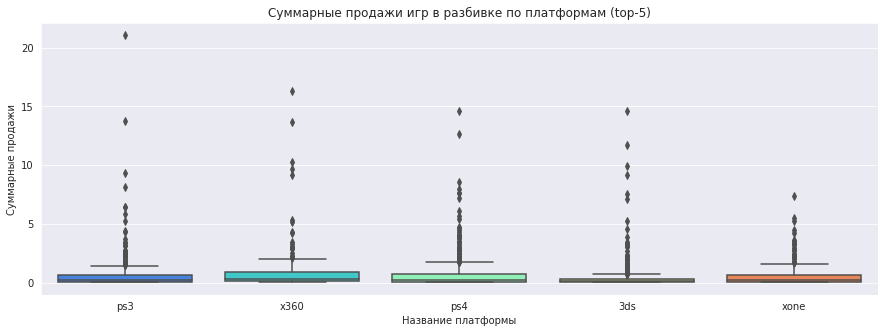

In [28]:
#сводная таблица продажи-платформы top-5 и boxplot
sales_sum_on_platform_top5 = games_up_2011[games_up_2011['platform'].isin(['ps4','ps3','x360','3ds','xone'])]

plt.figure(figsize=(15,5))
sns.boxplot(data=sales_sum_on_platform_top5, x='platform', y='sales_sum', palette='rainbow')
plt.title('Суммарные продажи игр в разбивке по платформам (top-5)')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи')

(0, 2.5)

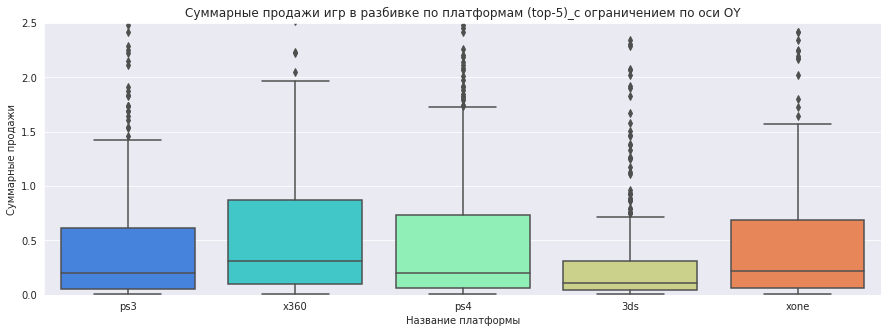

In [29]:
#сводная таблица продажи-платформы top-5 и boxplot
sales_sum_on_platform_top5 = games_up_2011[games_up_2011['platform'].isin(['ps4','ps3','x360','3ds','xone'])]

plt.figure(figsize=(15,5))
sns.boxplot(data=sales_sum_on_platform_top5, x='platform', y='sales_sum', palette='rainbow')
plt.title('Суммарные продажи игр в разбивке по платформам (top-5)_с ограничением по оси OY')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи')

plt.ylim(0, 2.5)

"Ящик с усами" по суммарным продажам игр в разбивке по платформам (top-5) неоднороден: медианы на разных уровнях, разброс выбросов разнится.
<br>Лидеры суммарных продаж *PS4, PS3, X360*, а XOne замыкает рейтинг, в 3DS отмечается наибольшее количество выбросов при наименьшем значении медианы (оставила XOne позади только за счет них).

##### Общие продажи и отзывы критиков/ пользователей, их корреляция


На примере наиболее популярной платформы PS4 отражена взаимосвязь продажи-отзывы пользователей и критиков и корреляция между ними.

Text(0.5, 1.01, 'Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе PS4')

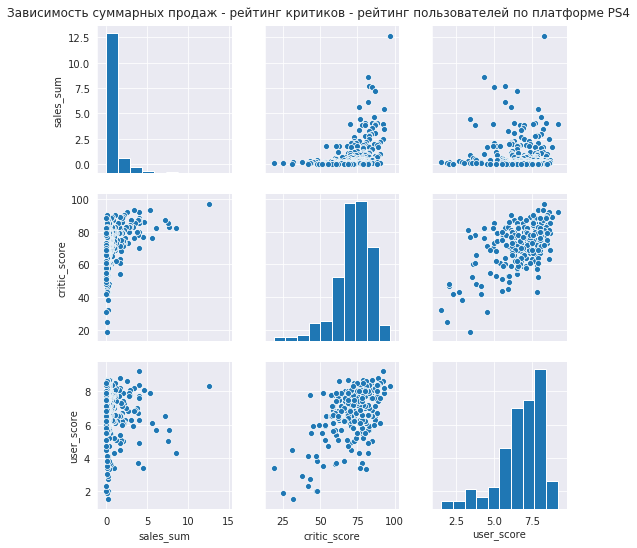

In [30]:
#гистограмма ps4 top-5 продажи-оценки: критиков/ пользователей
ps4 = games_up_2011[(games_up_2011['platform']=='ps4')]
sns.pairplot(ps4[['sales_sum','critic_score', 'user_score']])
plt.suptitle('Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе PS4', y=1.01)

In [31]:
#корреляция ps4 top-5 продажи-оценки: критиков/ пользователей
ps4['critic_score'].corr(ps4['sales_sum'])

0.40656790206178095

In [32]:
ps4['user_score'].corr(ps4['sales_sum'])

-0.031957110204556424

Присутствует корреляция между продажами и оценками пользователей/ критиков по платформе PS4. Корреляция продаж с критиками (0.41- критики, -0.03- пользователи)- доверие потенциальных покупателей к их экспертному мнению закономерно более весомо, чем учет мнения пользователей данной игры.

Аналогичные показатели по другим платформам top-5 следуют ниже. 

Text(0.5, 1.01, 'Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе PS3')

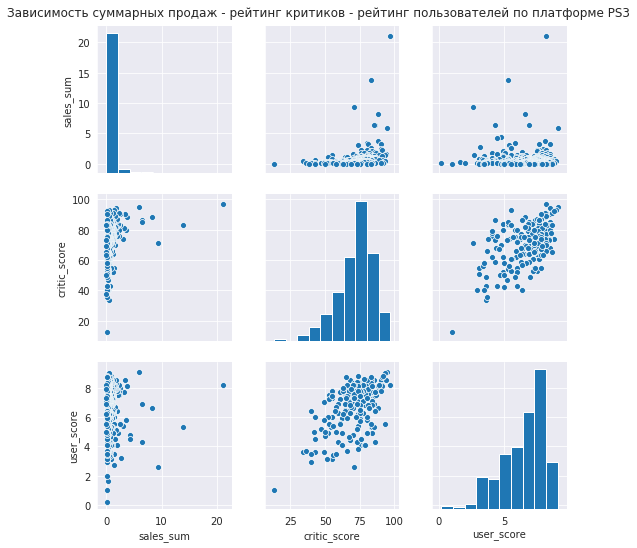

In [33]:
#гистограмма PS3
ps3 = games_up_2011[(games_up_2011['platform']=='ps3')]
sns.pairplot(ps3[['sales_sum','critic_score', 'user_score']])
plt.suptitle('Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе PS3', y=1.01)

In [34]:
ps3['critic_score'].corr(ps3['sales_sum'])

0.3314972592629587

In [35]:
ps3['user_score'].corr(ps3['sales_sum'])

-0.005143522887113815

Text(0.5, 1.01, 'Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе X360')

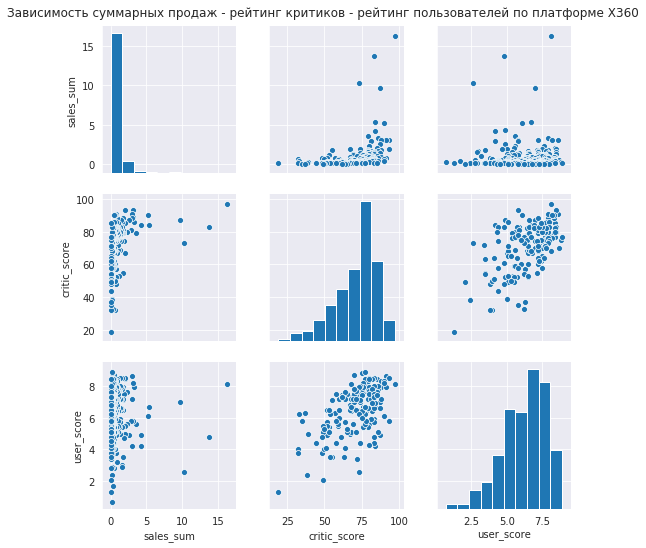

In [36]:
#гистограмма X360
x360 = games_up_2011[(games_up_2011['platform']=='x360')]
sns.pairplot(x360[['sales_sum','critic_score', 'user_score']])
plt.suptitle('Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе X360', y=1.01)

In [37]:
x360['critic_score'].corr(x360['sales_sum'])

0.3605734888507336

In [38]:
x360['user_score'].corr(x360['sales_sum'])

0.006163978646213326

Text(0.5, 1.01, 'Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе 3DS')

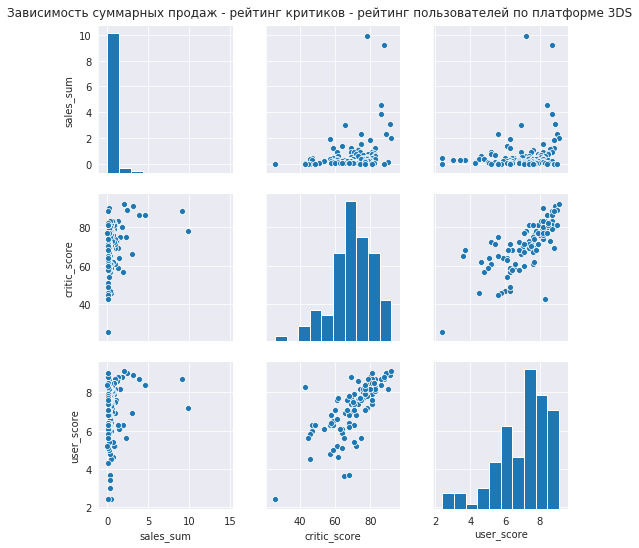

In [39]:
#гистограмма 3DS
ds3 = games_up_2011[(games_up_2011['platform']=='3ds')]
sns.pairplot(ds3[['sales_sum','critic_score', 'user_score']])
plt.suptitle('Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе 3DS', y=1.01)

In [40]:
ds3['critic_score'].corr(ds3['sales_sum'])

0.3208028695360785

In [41]:
ds3['user_score'].corr(ds3['sales_sum'])

0.19758263411038599

Text(0.5, 1.01, 'Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе XOne')

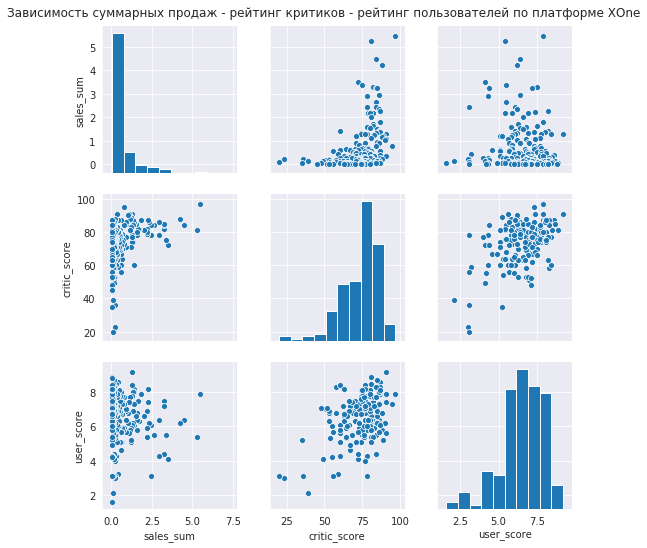

In [42]:
#гистограмма XOne
xone = games_up_2011[(games_up_2011['platform']=='xone')]
sns.pairplot(xone[['sales_sum','critic_score', 'user_score']])
plt.suptitle('Зависимость суммарных продаж - рейтинг критиков - рейтинг пользователей по платформе XOne', y=1.01)

In [43]:
xone['critic_score'].corr(xone['sales_sum'])

0.4169983280084017

In [44]:
xone['user_score'].corr(xone['sales_sum'])

-0.06892505328279414

На следующих платформах top-5 прослеживается закономерность аналогичная описанной по PS4: покупатели чаще слушают критиков (возможно основные лидеры пользуясь своим финансовым влиянием "помогают создавать" высокие рейтинги критикам), мнение пользователей оказывает незначительное влияние на их выбор при покупке. В частности, по платформе 3DS рейтинг критики/ пользователи наиболее приближен (0.32- критики, 0.20- пользователи)- качество продукта воспринято и критиками и пользователями примерно одинаково.

##### Общие продажи игр по жанрам

Распределение продаж по сумме и по медиане (без лишних выбросов) по жанрам игр демонстрирует существенное отличие по лидерам: по сумме продаж- 'action', 'shooter', 'role-playing' и по медиане- 'shooter', 'sports', 'platform', а вот закономерно у более "медитативных" продуктов 'strategy', 'puzzle', 'adventure' не такое большое число поклонников. Таким образом игры 'action' на первых позициях по суммарному количеству продаж, а 'shooter'- представляет пример прибыльного жанра.

Text(0, 0.5, 'Суммарные продажи')

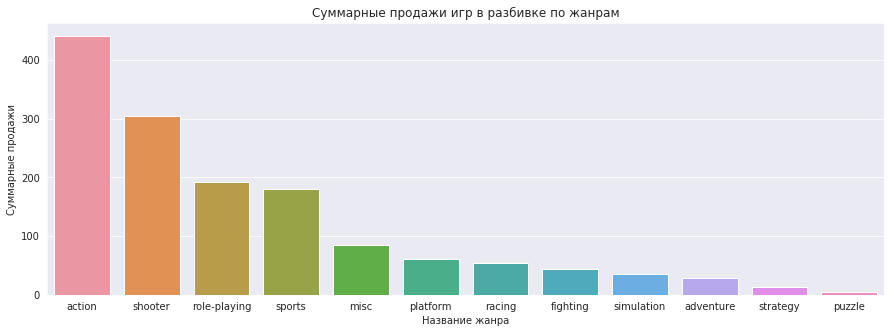

In [45]:
#сводная таблица продажи-жанр top-5 и гистограмма
sales_on_genre = games_up_2011.pivot_table(index='genre', values='sales_sum', aggfunc='sum').sort_values(by='sales_sum', ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(x=sales_on_genre.index,y=sales_on_genre['sales_sum'])
plt.title('Суммарные продажи игр в разбивке по жанрам')
plt.xlabel("Название жанра")
plt.ylabel("Суммарные продажи")

Text(0, 0.5, 'Суммарные продажи')

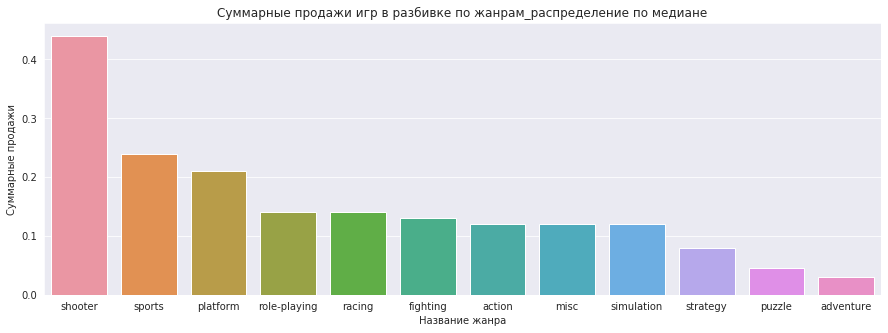

In [46]:
#сводная таблица продажи-жанр top-5 и гистограмма
sales_on_genre = games_up_2011.pivot_table(index='genre', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(x=sales_on_genre.index,y=sales_on_genre['sales_sum'])
plt.title('Суммарные продажи игр в разбивке по жанрам_распределение по медиане')
plt.xlabel("Название жанра")
plt.ylabel("Суммарные продажи")

##### Вывод:
Активное развитие индустрии компьютерных игр началось в 1990 году, также после 2007 года с популяризацией термина "мобильные приложения" начался спад  их продаж. <br>Самые популярные игровые платформы и приносящие высокие прибыли- PS4, PS3, X360. 
<br>В среднем платформы присутствуют на рынке 10 лет с пиком максимума приходящимся на середину этого периода.
<br>Влияние оценок критиков и пользователей на продажи имеет корреляцию причем критикам при покупках пользователи доверяю больше (особенно наиболее прибыльные платформы top-5 демонстрируют данный аспект).
<br> Жанр 'shooter' оказывается с большим отрывом стабильно более прибыльным и имеет видимые перспективы роста среди всех жанров, тогда как 'action' стал лидер по сумме продаж.

### Шаг 4. Составление портрета пользователя каждого региона

Определение для пользователя каждого региона (NA, EU, JP):
<br>Самые популярные платформы (топ-5). Различия в долях продаж.
<br>Самые популярные жанры (топ-5). Пояснение разницы.
<br>Влияние рейтинга ESRB на продажи в отдельном регионе.

##### Платформы (топ-5) для пользователей регионов продаж (NA, EU, JP)

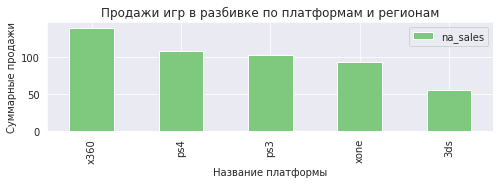

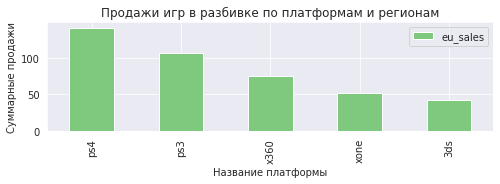

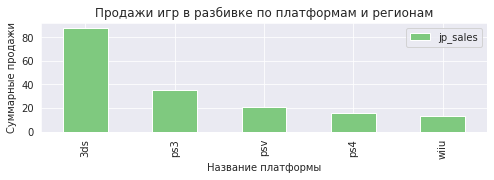

In [47]:
#гистограмма продажи по регионам top-5: платформы через цикл
for columns in ['na_sales', 'eu_sales', 'jp_sales']:
    (games_up_2011.pivot_table(index='platform', values=columns, aggfunc='sum').sort_values(by=columns, ascending=False).head(5)
    .plot.bar(figsize=(8, 2), colormap='Accent'))
    plt.title('Продажи игр в разбивке по платформам и регионам')
    plt.xlabel("Название платформы")
    plt.ylabel("Суммарные продажи")
    plt.show()  

По 3 регионам продаж установлены top-5 платформ. 
<br>В каждом регионе свои лидеры: 'na_sales'- X360 (в 'eu_sales' платформа только на 3 месте, а по 'jp_sales' вообще ниже top-5), 'eu_sales'- PS4 (в 'na_sales' и 'jp_sales'платформа на 2 месте и 4 месте соответственно), 'jp_sales'-3DS (в 'na_sales' и 'eu_sales' платформа только на 5 месте). 
<br>Аналогичная разрозненность оценок наблюдается по всем местам top-5.
<br>Вероятно у каждого региона свои предпочтения по выбору платформы (удобство сайта, продажи, доставка для пользователя, а также влияние менталитета и традиций рассматриваемого региона) или есть вероятность- система маркетинга каждой платформы по разным локациям работаем неодинаково эффективно.

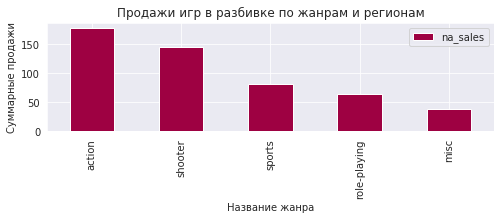

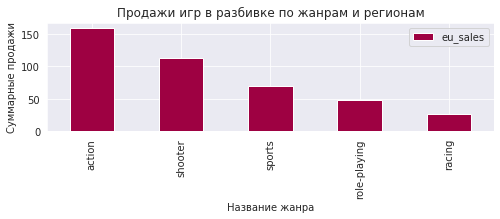

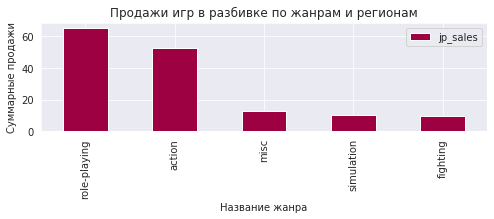

In [48]:
#гистограмма продажи по регионам top-5: жанры через цикл
for columns in ['na_sales', 'eu_sales', 'jp_sales']:
    (games_up_2011.pivot_table(index='genre', values=columns, aggfunc='sum').sort_values(by=columns, ascending=False).head(5)
    .plot.bar(figsize=(8, 2), colormap='Spectral'))
    plt.title('Продажи игр в разбивке по жанрам и регионам')
    plt.xlabel("Название жанра")
    plt.ylabel("Суммарные продажи")
    plt.show()  

top-5 жанров: 'na_sales' и 'eu_sales'- action, shooter, а в 'jp_sales'-role-playing (shooter в top-5 по региону вообще отсутствует).
<br>Рейтинг 'na_sales' и 'eu_sales' почти идентичен,а по 'jp_sales' наблюдается отличный от них порядок лидеров top-5.
<br>Менталитет и культурные особенности регионов и здесь находят свое отражение в разности поведения и предпочтениях пользователей.

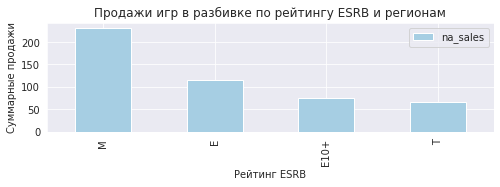

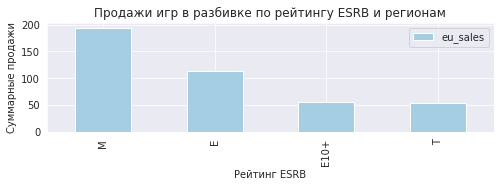

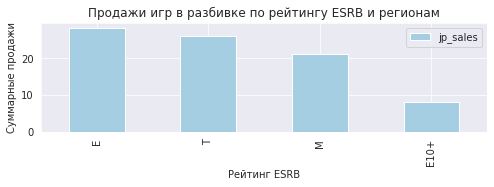

In [49]:
#гистограмма продажи по регионам top-5: рейтинг ESRB через цикл
for columns in ['na_sales', 'eu_sales', 'jp_sales']:
    (games_up_2011.pivot_table(index='rating', values=columns, aggfunc='sum').sort_values(by=columns, ascending=False).head(5)
    .plot.bar(figsize=(8, 2), colormap='Paired'))
    plt.title('Продажи игр в разбивке по рейтингу ESRB и регионам')
    plt.xlabel("Рейтинг ESRB")
    plt.ylabel("Суммарные продажи")
    plt.show()  

Помимо игр с обозначенным рейтингом в гистограмме по регионам продаж есть также игры 'X' ("без рейтинга")- 1275 позиций и их влияние немаловажно, а по региону Япония весьма существенно.

In [50]:
games_up_2011_X = games_up_2011[['na_sales', 'eu_sales', 'jp_sales', 'rating']].fillna(value='X')

In [51]:
games_up_2011_X['rating'].unique()

array(['M', 'X', 'E', 'E10+', 'T'], dtype=object)

In [52]:
games_up_2011_X

,na_sales,eu_sales,jp_sales,rating
16,7.02,9.09,0.98,M
23,9.66,5.14,0.06,M
31,6.03,5.86,0.36,X
33,5.28,4.19,4.35,X
34,4.99,5.73,0.65,M
...,...,...,...,...
16703,0.00,0.00,0.01,X
16707,0.00,0.00,0.01,X
16710,0.00,0.00,0.01,X
16712,0.00,0.00,0.01,X


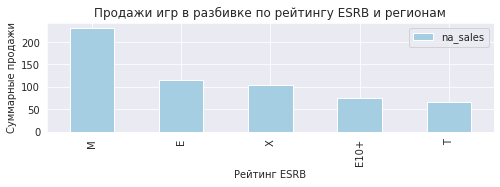

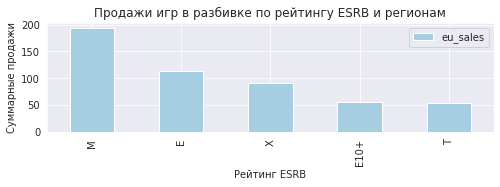

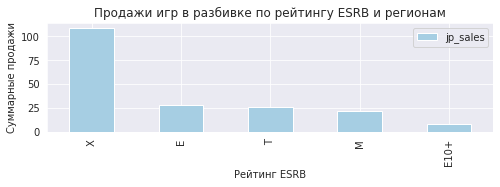

In [53]:
for columns in ['na_sales', 'eu_sales', 'jp_sales']:
    (games_up_2011_X.pivot_table(index=['rating'], values=columns, aggfunc='sum').sort_values(by=columns, ascending=False).head(5)
    .plot.bar(figsize=(8, 2), colormap='Paired'))
    plt.title('Продажи игр в разбивке по рейтингу ESRB и регионам')
    plt.xlabel("Рейтинг ESRB")
    plt.ylabel("Суммарные продажи")
    plt.show()  

<br>Рейтинг ESRB по регионам: жанр «M» («Mature») — «Для взрослых» и  следом за ним «E» («Everyone») — «Для всех» по 'na_sales' и 'eu_sales', а по 'jp_sales'- почти все игры без рейтинга!
<br>Остальные рейтинги по местам top-5 разнятся по регионам продаж, корреляция между показателями рейтинг ESRB-продажи: жанр «M» («Mature») — «Для взрослых» делает существенный прирост продаж, в частности в выборке есть NaN в размере 1275 позиций и для региона "Япония" он имеет абсолютное большинство (американский рейтинг ESRB не котирует в этом регионе). 

##### Вывод:
Предпочтения по выбору платформы, жанра и рейтинг ESRB по регионам продаж различны, есть сходные тренды по наполнению top-5 платформ, но лидерство в каждом регионе отдано своей платформе; по жанрам action- Европа и Северная Америка, в Японии закономерно менталитету его обогнал жанр role-playing; по рейтингу ESRB- игры «M» («Mature») — «Для взрослых» в Европе и Северной Америке, а в Японии- игры без рейтинга в абсолютном большинстве.

### Шаг 5. Проверка гипотезы

<br>Пояснение:
<br>Формулировка нулевой и альтернативной гипотезы;
<br>Какой критерий применим для проверки гипотез и почему.
<br>Задается самостоятельно пороговое значение alpha.

Пояснение:
<br>-формулировка нулевой и альтернативной гипотезы;
<br>-критерий для проверки гипотез и почему.

### Гипотеза_1

<br>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

<br>H0 — средние пользовательские рейтинги платформы Xbox One равны рейтингам PC.
<br>H1 — средние пользовательские рейтинги платформ Xbox One и PC различаются.

<br>α=5%

Для расчета гипотез заменим NaN в столбце 'user_score' на медиану (7.0).

In [54]:
games_up_2011['user_score'].describe() #просмотр основных статистических данных

count    1531.000000
mean        6.636120
std         1.569033
min         0.200000
25%         5.800000
50%         7.000000
75%         7.800000
max         9.300000
Name: user_score, dtype: float64

In [55]:
games_up_2011['user_score'] = games_up_2011['user_score'].fillna(7.0) 

Далее сформирована выборка средних пользовательских рейтингов по обозначенным платформам и дисперсия по ним.
<br>В следующей гипотезе порядок действий по жанрам идентичен.

In [56]:
xone = games_up_2011[(games_up_2011['platform']=='xone')] #срез по определенной платформе
pc = games_up_2011[(games_up_2011['platform']=='pc')]

In [57]:
np.var_xone=xone.pivot_table(index='platform',values=['user_score'],aggfunc=(np.var)) #дисперсия
np.var_xone

,user_score
platform,
xone,1.447706


In [58]:
np.var_pc=pc.pivot_table(index='platform',values=['user_score'],aggfunc=(np.var))
np.var_pc

,user_score
platform,
pc,2.328421


In [59]:
xone['user_score'].mean() #средний рейтинг

6.647368421052632

In [60]:
pc['user_score'].mean()

6.5291999999999994

Расчет results в гипотезах осуществлен методом scipy.stats.ttest_ind() с переданными параметрами array1, array2- массивами, содержащими выборки.
Добавлен параметр метода проверки 'equal_var = False' исходя из оценки дисперсий выборок- дисперсии выборок из генеральных совокупностей неравны и целесообразно их оценивать каждую отдельно по значениям дисперсий в них.


In [61]:
alpha = 0.05
results = st.ttest_ind(xone['user_score'], pc['user_score'], equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.3379157256732769
Не получилось отвергнуть нулевую гипотезу


##### Вывод:
<br>С уверенностью на 95% можно утвеждать, что платформы XOne и PC не отличаются по средней пользовательской оценке.
<br>p-value показывает близкое расстояние между средним и значением для сравнения- нулевая гипотеза верна.
<br>Данное утверждение подтверждается и фактическими средними значениями: XOne=6.65 и PC=6.53.

### Гипотеза_2

<br>Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

<br>H0 — средние пользовательские рейтинги жанров Action равны рейтингам Sports.
<br>H1 — средние пользовательские рейтинги жанров Action и Sports различаются.

<br>α=5%

In [62]:
action = games_up_2011[(games_up_2011['genre']=='action')]
sports = games_up_2011[(games_up_2011['genre']=='sports')]

In [63]:
np.var_action=action.pivot_table(index='genre',values=['user_score'],aggfunc=(np.var))
np.var_action

,user_score
genre,
action,0.965038


In [64]:
np.var_sports=sports.pivot_table(index='genre',values=['user_score'],aggfunc=(np.var))
np.var_sports

,user_score
genre,
sports,2.670719


In [65]:
action['user_score'].mean()

6.911251212415131

In [66]:
sports['user_score'].mean()

5.876492537313434

In [67]:
alpha = 0.05
results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 2.3313063772680757e-20
Отвергаем нулевую гипотезу


##### Вывод:
<br>С уверенностью на 95% можно утвеждать, что жанры Action и Sports отличаются по средней пользовательской оценке весьма значительно.
<br>p-value показывает значительную дальность между средним и значением для сравнения- нулевая гипотеза неверна.
<br>Данное утверждение подтверждается и фактическими средними значениями: action=6.91 и sports=5.88.

### Шаг 6. Общий вывод

Рынок компьютерных игр-  индустрия очень быстро меняющаяся, поэтому для выявления закономерностей был выбран период 2012-2016гг.
<br>Проведенный анализ продаж компьютерных игр выделяет следующие критерии успешного продукта:
<br>~ PC4, XOne- стабильный вектор роста в ближайшие годы (при начавшемся спаде платформ от пиковых значений) исходя из графиков продажи по годам (top-5);
<br>~ жанры action (при большом количестве выбросов) и более перспективный и прибыльный shooter, особенно при поддержке пользователей регионов Европа и Северная Америка;
<br>~ рейтинг ESRB- жанр «M» («Mature») для регионов Европы/ Северной Америке (по Японии сложно дать рекомендации, там почти все игры без рейтинга).